# Imports

In [102]:
from src.comet_utils import CometExe, run_comet_and_save_params_file, CometResult, read_comet_txt_to_df
from src.erik_constants import (
    SPECTRA_DIR, COMET_EXECUTABLE, COMET_PARAMS, samples, COMET_RUN_1_DIR, COMET_RUN_2_DIR, PLAIN_PEPTIDE,
    CHARGE
)
import pandas as pd
from src.plot_utils import fig_setup, finalize, set_title_axes_labels
from src.erik_utils import abs_relative_change, pydantic_models_to_df
import seaborn as sns
from src.erik import parse_mzml, get_data_for_spectrum, get_specific_spectrum, compute_theoretical_mass_over_charge, Peptide, get_theoretical_b_y_ion_mass_spectrum

import warnings
warnings.filterwarnings('ignore')

ENM, CNM = "exp_neutral_mass", "calc_neutral_mass"
XC = "xcorr"
EV = "e-value"
DCN = "delta_cn"
SPS = "sp_score"
IM = "ions_matched"


# Running Comet

- [Running documentation](https://uwpr.github.io/Comet/notes/)
- See help page: `./comet.macos.exe`
- Running `path1/comet.macos.exe path2/spectra.mzML` only works if there's a `comet.params` file in the current working directory.
- Running `./comet.macos.exe ../data/spectra/BMEM_AspN_Fxn4.mzML -Npath3/blah` runs comet on `BMEM_AspN_Fxn4.mzML` and creates outputs `path3/blah.pep.xml` (contains parameter settings) and `path3/blah.txt` (which contains Comet results). If `path3` doesn't exist, Comet will fail. If `path3/blah.pep.xml` and/or `path3/blah.txt` already exist, they will be overwritten

In [58]:
mzml_path = SPECTRA_DIR / f"{samples[0]}.mzML"
comet = CometExe(exe=COMET_EXECUTABLE, params=COMET_PARAMS)

for sample in samples:
    print(f"Running Comet on {sample}")
    mzml_path = SPECTRA_DIR / f"{sample}.mzML"

    result = run_comet_and_save_params_file(
        mzml_path=mzml_path,
        comet=comet,
        parent_output_dir=COMET_RUN_1_DIR
    )


# Load Comet run 1 data

In [61]:
comet_dfs = []
for sample in samples:
    print(f"Reading data for {sample}")
    comet_output = COMET_RUN_1_DIR / f"{sample}/{sample}.txt"
    comet_dfs.append(read_comet_txt_to_df(txt_path=comet_output))
    # hs_data.extend(HSResult.from_txt(hs_output))
comet_df = pd.concat(comet_dfs, ignore_index=True)

Reading data for BMEM_AspN_Fxn4
Reading data for BMEM_AspN_Fxn5
Reading data for BMEM_AspN_Fxn6
Reading data for BMEM_AspN_Fxn7
Reading data for BMEM_AspN_Fxn8
Reading data for BMEM_AspN_Fxn9


In [5]:
comet_df.dtypes[ENM]
comet_df.head(2)
comet_df["num"].unique()

dtype('float64')

,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,...,plain_peptide,modified_peptide,prev_aa,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank,sample
0,7,1,3,1525.774133,1525.773636,0.000202,2.187,0.4294,229.0,15,...,SAAPAAGSAPAAAEEKK,G.SAAPAAGSAPAAAEEKK.D,G,D,"tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE,sp|P99027|RLA2_...",2,-,714.0,1,BMEM_AspN_Fxn4
1,7,2,3,1525.774133,1525.773636,2.030000,1.248,0.0200,26.0,6,...,AAQTPGSGEAVLSKNP,T.AAQTPGSGEAVLSKNP.N,T,N,sp|Q8BI84|TGO1_MOUSE,1,-,714.0,16,BMEM_AspN_Fxn4


array([1, 2, 3, 4, 5])

## exp_neutral_mass & calc_neutral_mass

In [1]:
def count_decimal_digits(number):
    num_str = str(number).split(".")
    return len(num_str[1]) if len(num_str) > 1 else 0

max_decimal_digits = max([
    max(comet_df[ENM].apply(lambda x: count_decimal_digits(x))),
    max(comet_df[CNM].apply(lambda x: count_decimal_digits(x)))
])
max_decimal_digits

NameError: name 'comet_df' is not defined

(-20.0, 20.0)

(0.0, 20.0)

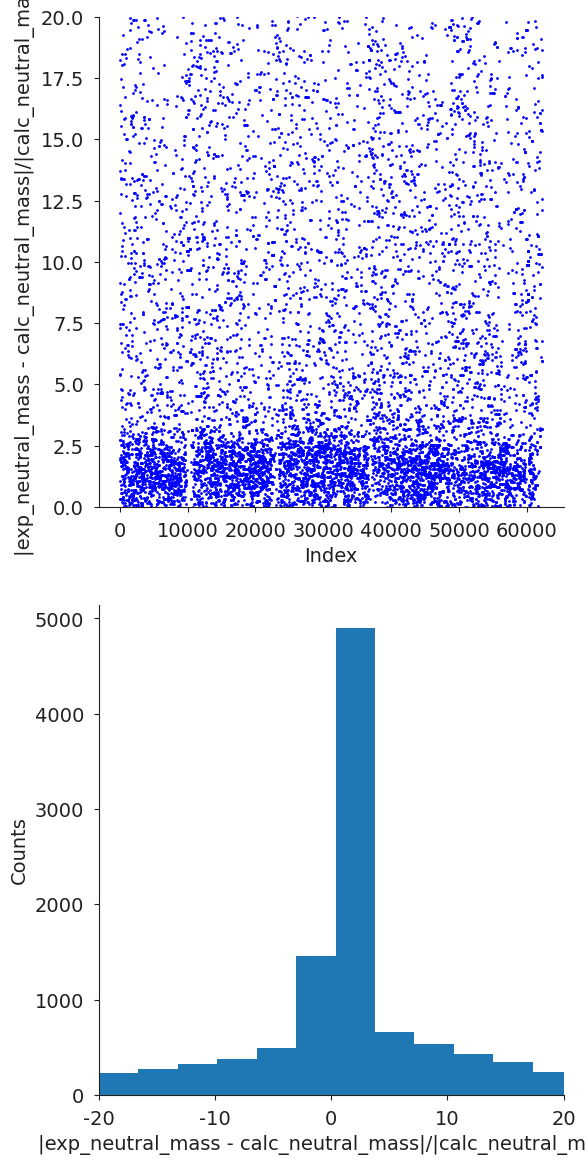

In [23]:
import numpy as np


_, axs = fig_setup(2, 1, h=7)

obs = comet_df[comet_df["num"]==1][ENM]
ref = comet_df[comet_df["num"]==1][CNM]
_=axs[0].plot(
    abs_relative_change(obs=obs, ref=ref) * 10**6,
    'b.',
    ms=2,
)
label = f"|{ENM} - {CNM}|/|{CNM}|"
set_title_axes_labels(
    axs[0], xlabel="Index", 
    ylabel=label
)
_=axs[1].hist(
    ((obs - ref) / ref) * 10**6,
    bins=1000
)
set_title_axes_labels(
    axs[1], xlabel=label, 
    ylabel="Counts"
)
axs[1].set_xlim(left=-20, right=20)
axs[0].set_ylim(bottom=0, top=20)
finalize(axs)

In [ ]:
# Right now (11/12/2024) we're not considering modifications in Comet run 1
# so there should be no modifications
all(comet_df["modifications"]=="-") is True

# 

True

## Distribution of scores

### By rank

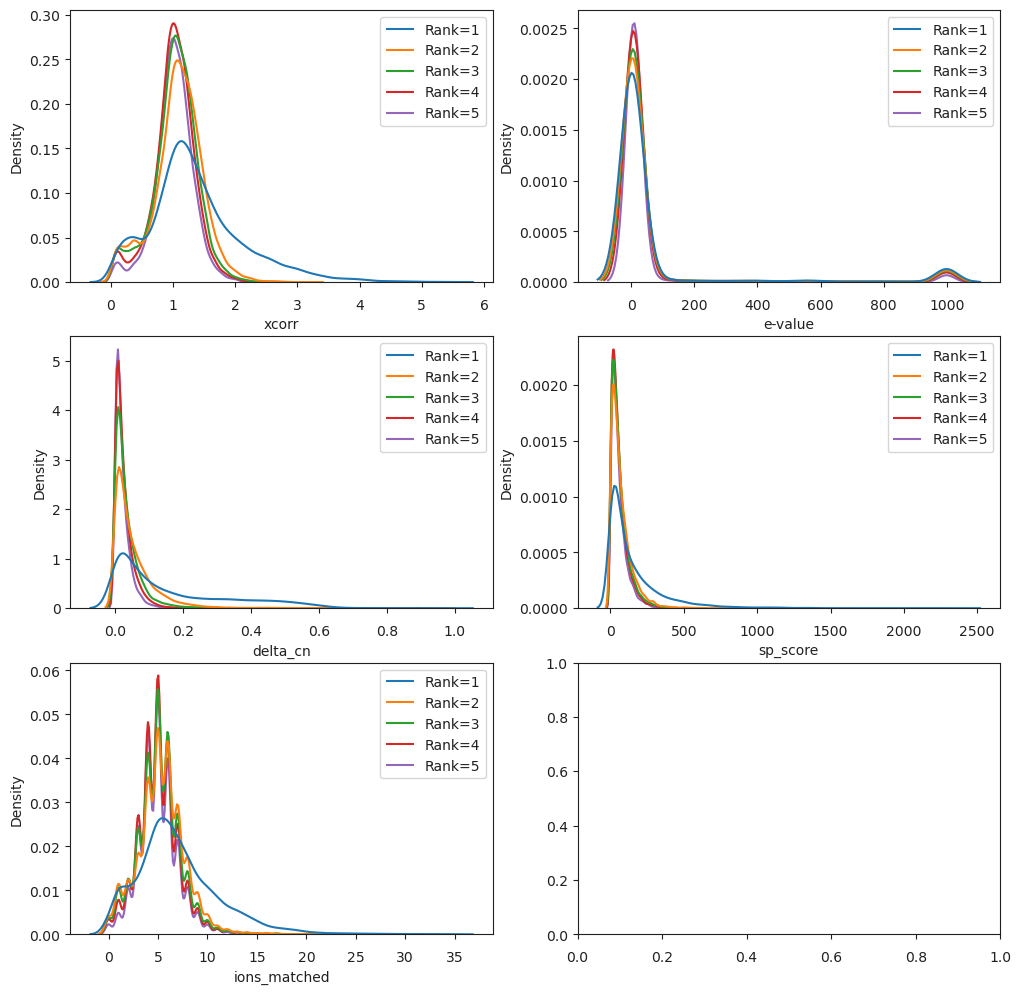

In [7]:
# for rank in pd.
from typing import Counter



_, axs = fig_setup(3, 2)
def score_plot(comet_df, score, ax):
    score_by_rank = {}
    for rank in comet_df["num"].unique():
        score_by_rank[f"Rank={int(rank)}"] = comet_df[comet_df["num"]==rank][score]

    sns.kdeplot(data=score_by_rank, ax=ax)
    set_title_axes_labels(ax, xlabel=f"{score}", ylabel="Density")

score_plot(comet_df=comet_df, score=XC, ax=axs[0])
score_plot(comet_df=comet_df, score=EV, ax=axs[1])
score_plot(comet_df=comet_df, score=DCN, ax=axs[2])
score_plot(comet_df=comet_df, score=SPS, ax=axs[3])
score_plot(comet_df=comet_df, score=IM, ax=axs[4])

### By sample and rank

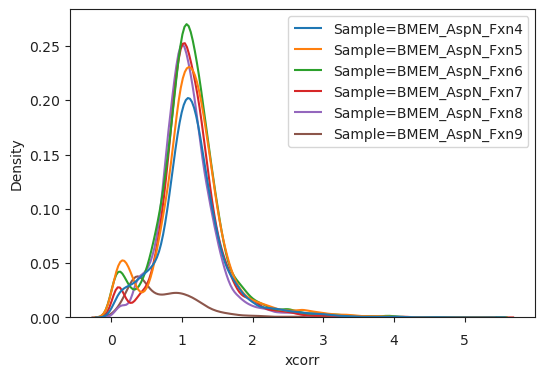

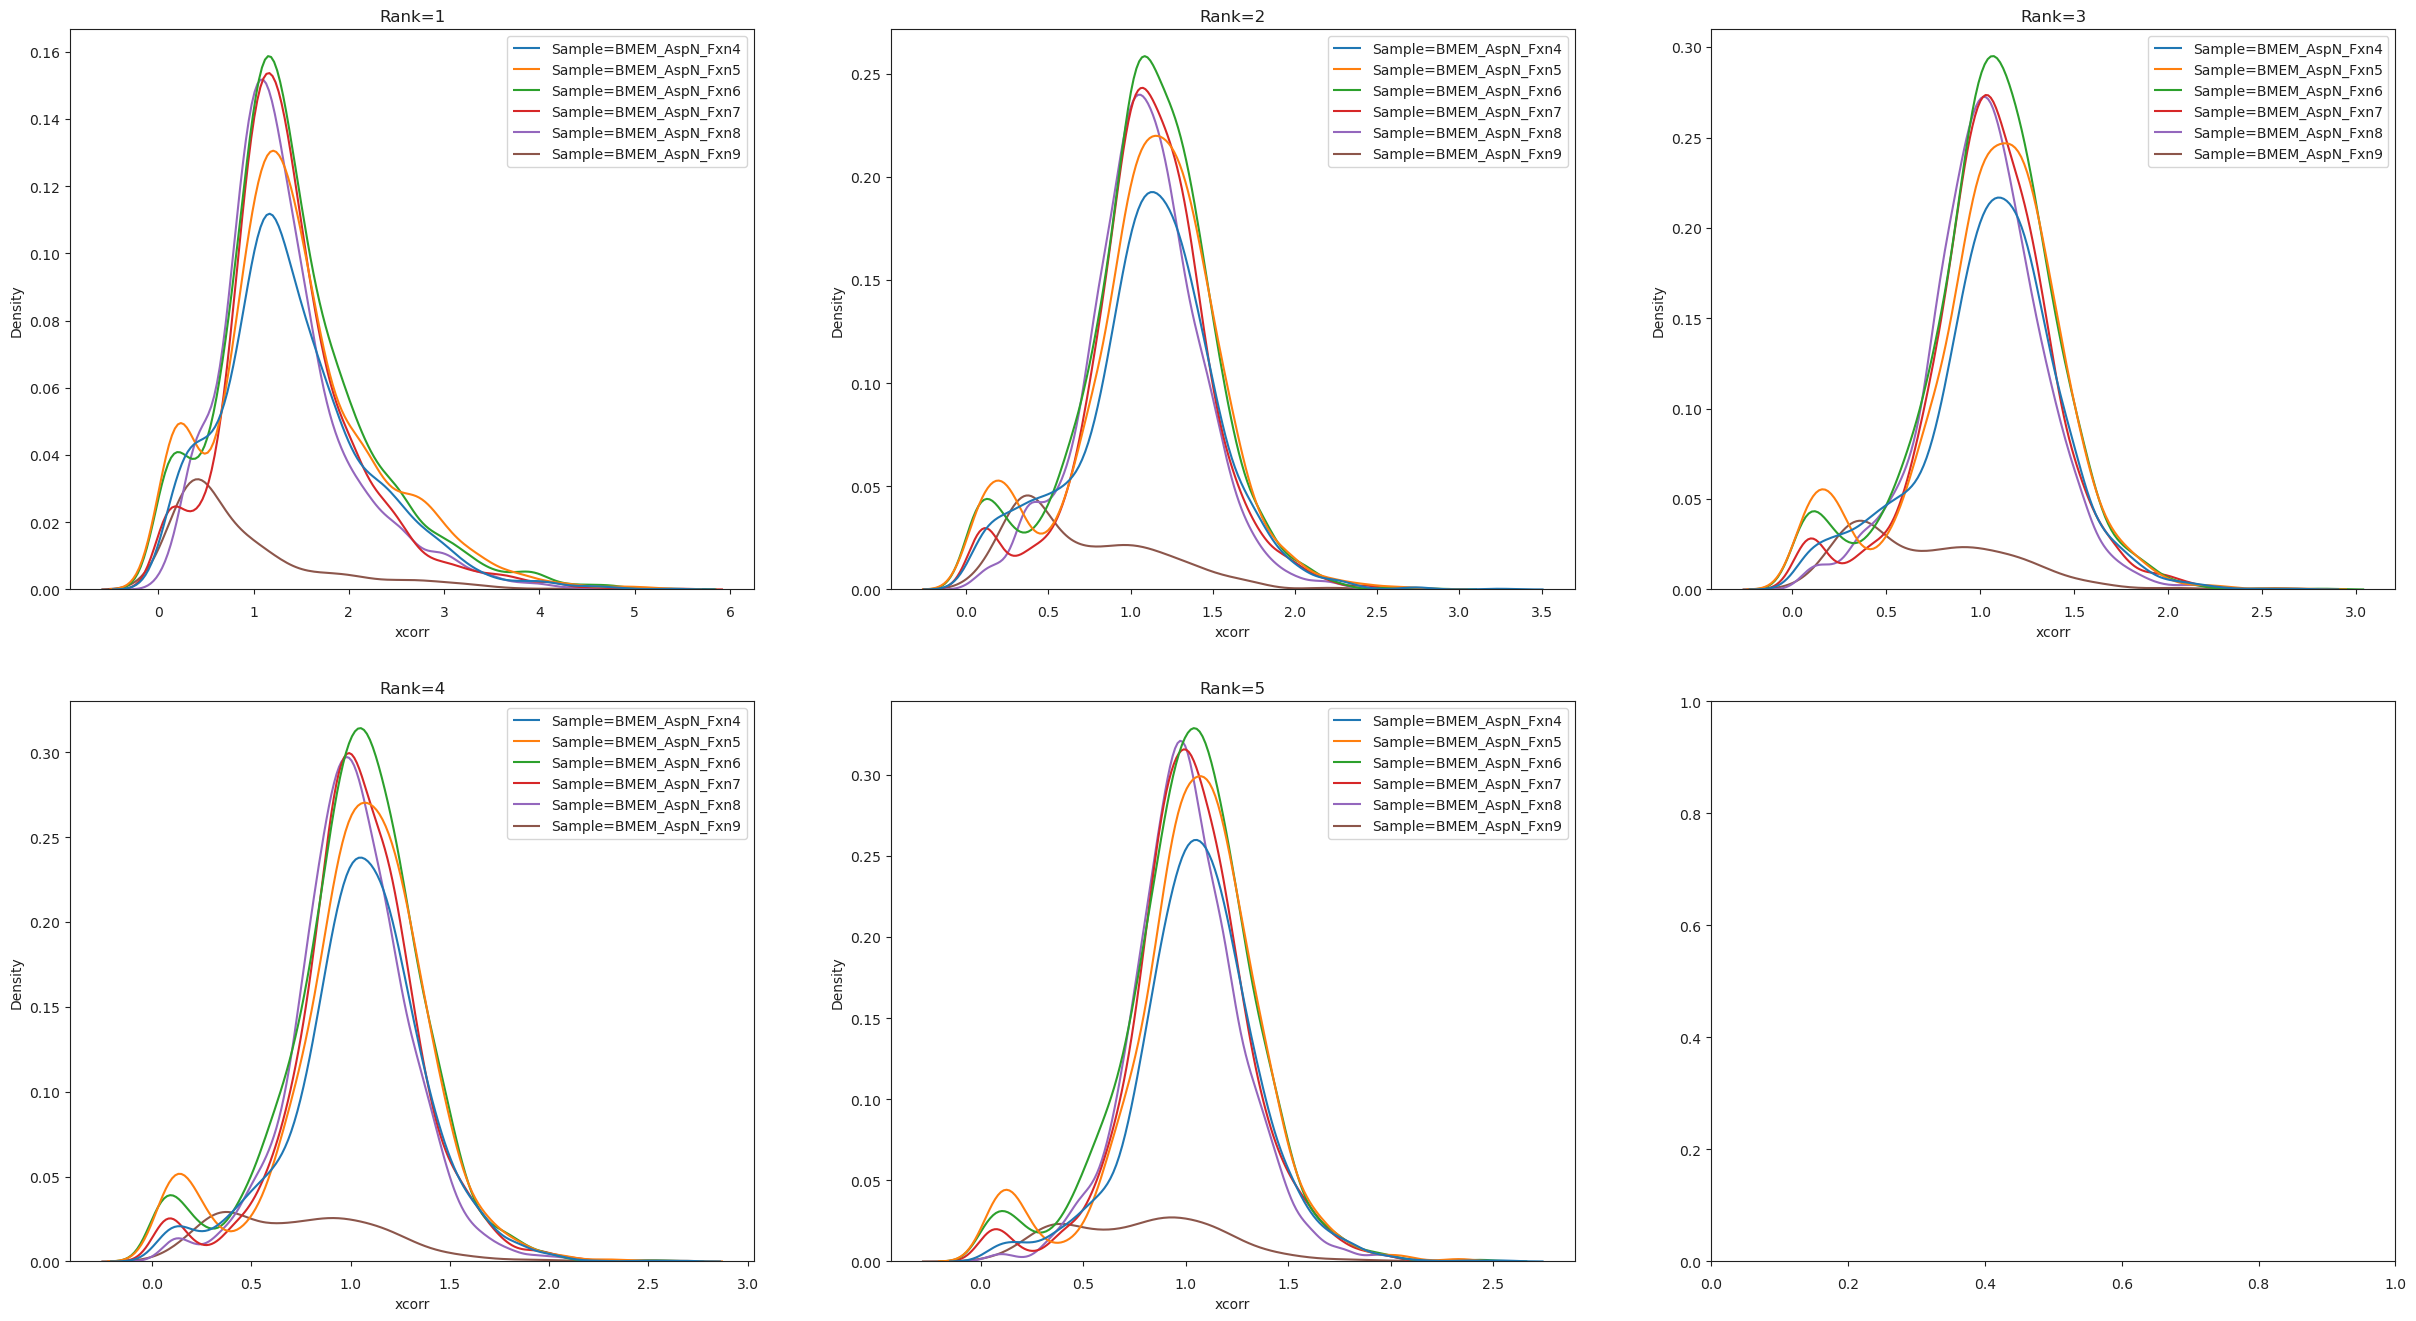

In [17]:
# By sample

score = {}
for sample in comet_df["sample"].unique():
    score[f"Sample={sample}"] = comet_df[comet_df["sample"]==sample][XC]

_, axs = fig_setup(1,1)
_=sns.kdeplot(data=score, ax=axs[0])
set_title_axes_labels(axs[0], xlabel=f"xcorr", ylabel="Density")

_, axs = fig_setup(2,3, w=10, h=8)
for rank_num, rank in enumerate(comet_df["num"].unique()):
    score = {}
    for sample in comet_df["sample"].unique():
        score[f"Sample={sample}"] = comet_df[
            (comet_df["sample"]==sample) & (comet_df["num"] == rank)
        ][XC]

    _=sns.kdeplot(data=score, ax=axs[rank_num])
    set_title_axes_labels(axs[rank_num], xlabel=f"xcorr", ylabel="Density", title=f"Rank={rank}")

# Comet columns EDA

## ions_matched

(np.int64(0), np.int64(35))

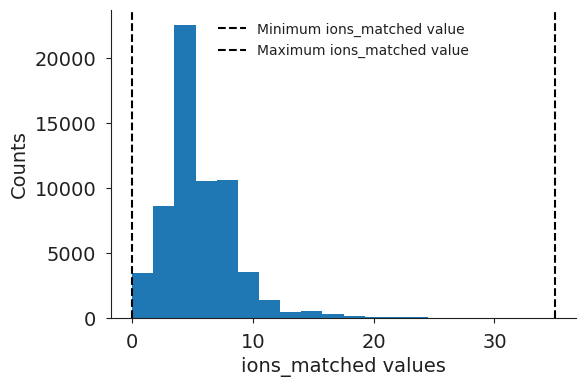

In [97]:
colm = "ions_matched"
np.min(comet_df[colm]), np.max(comet_df[colm])
_, axs = fig_setup(1,1)
_=axs[0].hist(comet_df[colm], bins=20)
_=axs[0].axvline(
    x=np.min(comet_df[colm]),
    color="black",
    linestyle="--",
    label=f"Minimum {colm} value"
)
_=axs[0].axvline(
    x=np.max(comet_df[colm]),
    color="black",
    linestyle="--",
    label=f"Maximum {colm} value"
)
set_title_axes_labels(axs[0], xlabel="ions_matched values", ylabel="Counts")
finalize(axs)

# High scoring Comet run 1 peptides

Number of ions_matched=32


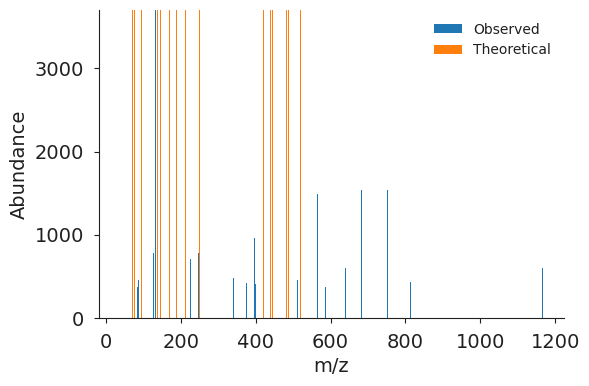

In [111]:
from src.erik import get_indices_of_largest_elements
from src.erik_constants import SAMPLE, SCAN
TOP_N_PEAKS = 50

# Sort comet run 1 df so highest xcorr rows are on top
df = comet_df.sort_values(by="xcorr", ascending=False)
df.reset_index(inplace=True, drop=True)
for sample, sample_df in df.groupby("sample"):
    # sample_df.head(2)

    # Get spectrum for a Comet row
    row = sample_df.iloc[0]
    print(f"Number of ions_matched={row['ions_matched']}")
    spectrum = get_specific_spectrum(sample=row[SAMPLE], scan_num=row[SCAN])

    # Get indices of highest abundance ions
    highest_abundance_indices = get_indices_of_largest_elements(
        array=spectrum["abundances"],
        top_n=TOP_N_PEAKS
    )
    
    # Observed spectrum
    _, axs = fig_setup()
    obs_mz_values = np.array(spectrum["mass_over_charges"])[highest_abundance_indices]
    obs_abundances = np.array(spectrum["abundances"])[highest_abundance_indices]
    _=axs[0].bar(obs_mz_values, obs_abundances, width=1, label="Observed")
    set_title_axes_labels(axs[0], xlabel="m/z", ylabel="Abundance")

    # Theoretical spectrum
    const_ab = max(obs_abundances)/3
    theory_spectrum = get_theoretical_b_y_ion_mass_spectrum(peptide=row[PLAIN_PEPTIDE], const_abundance=const_ab, charge=row[CHARGE])
    theory_mz_values = np.array([peak.mz for peak in theory_spectrum])
    theory_abundances = np.array([peak.abundance for peak in theory_spectrum])
    _=axs[0].bar(theory_mz_values, theory_abundances, width=1, label="Theoretical")
    set_title_axes_labels(axs[0], xlabel="m/z", ylabel="Abundance")
    _=axs[0].set_ylim(top=const_ab)
    finalize(axs)
    
    break

In [130]:
# For each observed peak/ion, see if there's a theoretical ion
# within +- X ppm
PPM_TOL = 5

len(obs_mz_values)
for obs_mz in obs_mz_values:
    mass_tol = (PPM_TOL/(10**6)) * obs_mz
    print(f"mz={obs_mz}, mass_tol={mass_tol}")

    tmp = np.min(np.abs(theory_mz_values - obs_mz))
    print(f"\tThe closest theoretical mass is {tmp} Da away")
    
    # np.any((theory_mz_values <= obs_mz + mass_tol) & (theory_mz_values >= obs_mz - mass_tol))

    # theory_mz_values
    # break

# mass_tol = PPM_TOL



50

mz=70.06481170654297, mass_tol=0.00035032405853271486
	The closest theoretical mass is 0.6284239601236976 Da away
mz=84.0438232421875, mass_tol=0.0004202191162109375
	The closest theoretical mass is 8.006820908854166 Da away
mz=86.09635162353516, mass_tol=0.0004304817581176758
	The closest theoretical mass is 8.947805376464842 Da away
mz=87.0993881225586, mass_tol=0.000435496940612793
	The closest theoretical mass is 7.944768877441405 Da away
mz=88.03766632080078, mass_tol=0.00044018833160400396
	The closest theoretical mass is 7.006490679199217 Da away
mz=88.04029083251953, mass_tol=0.0004402014541625977
	The closest theoretical mass is 7.003866167480467 Da away
mz=101.06817626953125, mass_tol=0.0005053408813476563
	The closest theoretical mass is 6.0240192695312516 Da away
mz=102.05368041992188, mass_tol=0.0005102684020996094
	The closest theoretical mass is 7.0095234199218766 Da away
mz=127.05029296875, mass_tol=0.0006352514648437501
	The closest theoretical mass is 8.32709796874998

In [121]:
obs_mz_values
theory_mz_values

array([  70.06481171,   84.04382324,   86.09635162,   87.09938812,
         88.03766632,   88.04029083,  101.06817627,  102.05368042,
        127.05029297,  129.06488037,  132.10119629,  133.1036377 ,
        155.0796051 ,  212.1027832 ,  226.11790466,  247.12449646,
        247.12988281,  248.13146973,  286.14105225,  304.14926147,
        326.13980103,  341.14511108,  375.19006348,  376.6963501 ,
        397.18191528,  398.16815186,  399.17205811,  440.21334839,
        441.22119141,  441.72323608,  455.18869019,  511.25247192,
        512.25177002,  529.26031494,  564.92169189,  565.25402832,
        569.23266602,  583.28686523,  586.28167725,  639.31018066,
        640.30969238,  643.30529785,  660.32781982,  682.31890869,
        700.32647705,  752.39141846,  813.40808105,  881.43640137,
        882.44049072, 1165.58349609])

array([ 38.34231433,  70.69323567, 113.37942833, 146.402233  ,
       170.081271  , 212.76746367, 250.46215167, 293.47634933,
       331.17103733, 350.178192  , 369.18534667, 388.19250133,
       420.54342267, 439.55057733, 463.22961533, 482.23677   ,
       520.57908433, 558.27377233, 519.931458  , 487.58053667,
       444.894344  , 411.87153933, 388.19250133, 345.50630867,
       307.81162067, 264.797423  , 227.102735  , 208.09558033,
       189.08842567, 170.081271  , 137.73034967, 118.723195  ,
        95.044157  ,  76.03700233,  37.694688  ])

In [80]:
from src.erik import get_indices_of_largest_elements

spectrum

,mass_over_charges,abundances,precursor_mass,precursor_charge,precursor_abundance,spectrum_id,retention_time,peaks
3855,"(65.55867767333984, 70.0269775390625, 70.06481...","(31.450000762939453, 140.66744995117188, 1611....",565.285546,3,1400745.23,scan=3856,2259.0,"({'mz': 65.55867767333984, 'abundance': 31.450..."


In [58]:
df

NameError: name 'df' is not defined

<BarContainer object of 712 artists>

<BarContainer object of 25 artists>

(0.0, 1500.0)

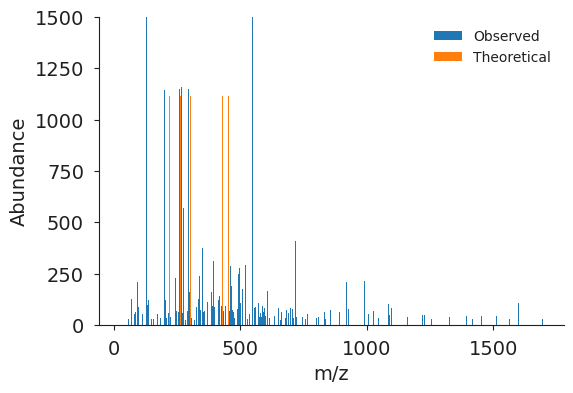

In [ ]:
# Observed spectrum
obs_mz_values = spectrum.iloc[0]["mass_over_charges"]
obs_abundances = spectrum.iloc[0]["abundances"]
_, axs = fig_setup()
axs[0].bar(obs_mz_values, obs_abundances, width=1, label="Observed")
set_title_axes_labels(axs[0], xlabel="m/z", ylabel="Abundance")

# Theoretical spectrum
const_ab = max(spectrum.iloc[0]["abundances"])/5
theory_spectrum = get_theoretical_b_y_ion_mass_spectrum(peptide=row[PLAIN_PEPTIDE], const_abundance=const_ab, charge=row[CHARGE])
obs_mz_values = [peak.mz for peak in theory_spectrum]
obs_abundances = [peak.abundance for peak in theory_spectrum]
# _, axs = fig_setup()
axs[0].bar(obs_mz_values, obs_abundances, width=1, label="Theoretical")
set_title_axes_labels(axs[0], xlabel="m/z", ylabel="Abundance")
axs[0].set_ylim(top=1500)
finalize(axs)

# How much does only considering the proteins returned by Comet run 1 reduce the search space of proteins?

Number of proteins in FASTA = 21759
	Sample = BMEM_AspN_Fxn4; num proteins in Comet run 1 output = 6902
	Sample = BMEM_AspN_Fxn5; num proteins in Comet run 1 output = 7394
	Sample = BMEM_AspN_Fxn6; num proteins in Comet run 1 output = 8081
	Sample = BMEM_AspN_Fxn7; num proteins in Comet run 1 output = 7727
	Sample = BMEM_AspN_Fxn8; num proteins in Comet run 1 output = 7487
	Sample = BMEM_AspN_Fxn9; num proteins in Comet run 1 output = 2075


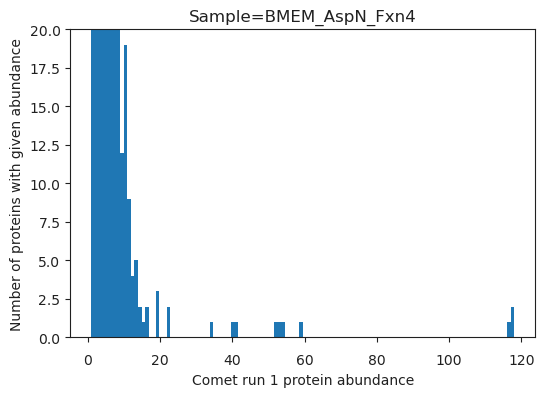

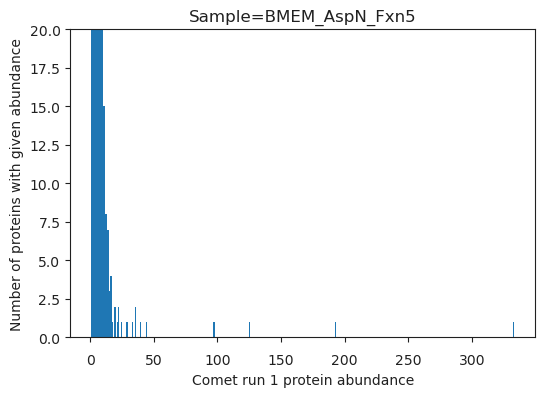

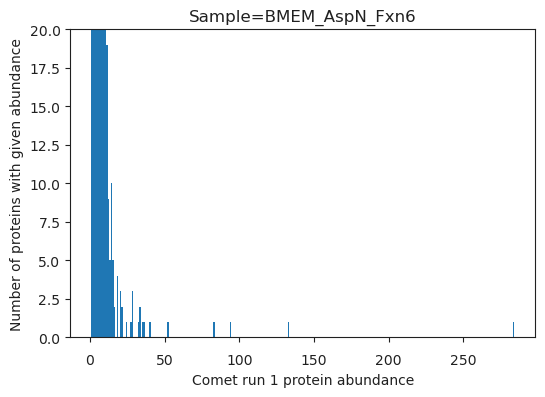

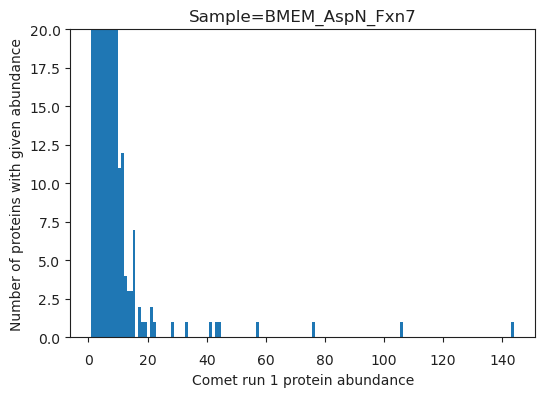

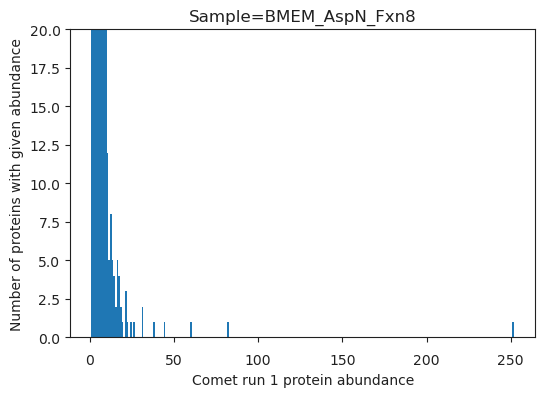

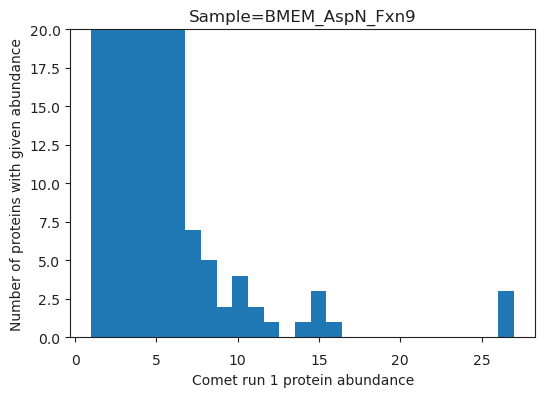

In [54]:
from collections import Counter
from src.erik_constants import MOUSE_PROTEOME
from src.erik_utils import get_proteins_from_fasta

fasta_proteins = list(get_proteins_from_fasta(fasta_path=MOUSE_PROTEOME))
fasta_proteins = [protein.desc.split(" ")[0] for protein in fasta_proteins]
fasta_proteins = [protein.split("|")[1] for protein in fasta_proteins]
print(f"Number of proteins in FASTA = {len(set(fasta_proteins))}")
for sample in samples:
    comet_output = COMET_RUN_1_DIR / f"{sample}/{sample}.txt"
    comet_data = CometResult.from_txt(comet_output)

    # Get abundances of non-decoy proteins
    comet_proteins = [protein for row in comet_data for protein in row.proteins]
    comet_proteins = [protein for protein in comet_proteins if "DECOY" not in protein]
    # comet_proteins[:10]
    # Protein names in Comet are "<str1>|<str2>|<str3>"
    # Update them to just be "<str3>" to match HS's output
    comet_proteins = [protein.split("|")[1] for protein in comet_proteins]

    
    _, axs = fig_setup(1,1)
    x = Counter(comet_proteins).values()
    _=axs[0].hist(
        x,
        bins=max(x)
    )
    _=axs[0].set_ylim(top=20)
    set_title_axes_labels(
        axs[0], title=f"Sample={sample}", xlabel="Comet run 1 protein abundance",
        ylabel="Number of proteins with given abundance"
    )
    print(
        f"\tSample = {sample}; num proteins in Comet run 1 output = {len(set(comet_proteins))}"
    )
    # break



In [50]:
max(x)

27

In [46]:


Counter(comet_proteins).values()

dict_values([1, 1, 1, 1, 1, 6, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 6, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 11, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 15, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 15, 1, 1, 2, 3, 4, 3, 6, 6, 1, 1, 6, 1, 5, 1, 2, 1, 3, 1, 1, 1, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 8, 3, 5, 1, 1, 1, 1, 2, 1, 1, 1, 1, 10, 2, 3, 1, 1, 3, 1, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 3, 2, 2, 1, 2, 3, 1, 1, 3

### Questions

<span style="color:red">

- Why are counts in `Counter(comet_df["num"])` not equal?
</span>

# Comet columns (from Jimmy)

- scan: The scan number of the spectrum that was searched.
- num: For each scan, the top N best scoring peptides are returned, controlled by the [num_output_lines](https://uwpr.github.io/Comet/parameters/parameters_202401/num_output_lines.html) parameter. This column displays the peptide order for each scan, starting at "1" to indicate the top scoring peptide, "2" to indicate the second best scoring peptide, etc.
- charge: The precursor charge state
- exp_neutral_mass: The experimental neutral mass of the measured precursor ion.
- calc_neutral_mass: The calculated neutral mass of the matched peptide.
- e_value: The expectation value or E-value score for the peptide. Some [info in this paper](https://pubs.acs.org/doi/10.1021/pr800420s) on how Comet calculates E-values (although there is a correction to one detail in the paper on the calculation).
- xcorr: The cross correlation score for the peptide. Here's a [very nice illustration of how this score is calculated](https://willfondrie.com/2019/02/an-intuitive-look-at-the-xcorr-score-function-in-proteomics/) by Will Fondrie.
- delta_cn: The deltaCn which is the difference in the normalized cross correlation score, historically between top hit and next best hit. In Comet, each deltaCn score for each row is the difference in the normalized cross correlation score between that hit and next lower peptide hit.
- sp_score: The preliminary score which is the sum of peak intensities that match the peptide and accounts for continuity of an ion series and the length of the peptide. I think of this as a quick/simple peptide match score that now exists only for backwards compatibility for post-search processing tools.
- ions_matched: Out of the total number of theoretical fragment ions being considered in the search, this is the number of those ions that were found in the experimental spectrum.
- ions_total: The total number of theoretical fragment ions for the peptide.
- plain_peptide: The raw peptide sequence.
- modified_peptide: The peptide sequence including previous and next amino acids as well as any variable modifications.
- prev_aa: In the first protein that contains this peptide, the amino acid just before or n-terminal to the peptide.
- next_aa: In the first protein that contains this peptide, the amino acid just after or c-terminal to the peptide.
- protein: The first protein in the database that contains the peptide.
- protein_count: The total number of proteins in the database that contains the peptide.
- modifications: An encoding of static and variable modifications in the peptide. See the documentation in [output_txtfile](https://uwpr.github.io/Comet/parameters/parameters_202401/output_txtfile.html) for explanation of this encoding.
- retention_time_sec: If available from the query file, this reports the retention time in seconds of the spectrum being searched.
- sp_rank: The rank of the preliminary score (Sp). If the peptide results were ordered by the sp_score column, this column reports the rank order of this peptide when sorted by sp_score. So if this peptide had the fourth highest sp_score, this column would contain a "4".